In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hydroeval import evaluator, nse, kge, pbias
from tqdm import tqdm
import datetime as dt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mpl
import matplotlib.colors as pltc
import geopandas
import mapclassify
import seaborn as sns
mpl.rcParams['pdf.fonttype'] = 42

In [5]:
df = pd.read_csv("../data/pnwNP_modelStats_DELETEME.csv")
df = df[["gage", "model",'kge','kge_r','kge_a','kge_b']]

In [7]:
tt = df
tt = tt.melt(id_vars=["gage", "model"], var_name="metric", value_name="value")
tt['value']=tt['value'].astype(float)
# tt = tt.dropna()
tt = tt[~tt["value"].isin([np.nan, np.inf, -np.inf])]
tmp=tt.reset_index(drop=True)

In [8]:
df = pd.read_csv("../data/pnwNP_StatsLocations.csv")
df = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.dec_long_va,df.dec_lat_va)).set_crs('epsg:4269')

In [9]:
tmp = df[["site_no","dec_lat_va","dec_long_va"]]
mapKGE = pd.merge(tt,tmp,left_on="gage",right_on="site_no").reset_index(drop=True)

mapKGE = geopandas.GeoDataFrame(mapKGE, geometry=geopandas.points_from_xy(mapKGE.dec_long_va,mapKGE.dec_lat_va)).set_crs('epsg:4269')

In [10]:
pnw_hydro = geopandas.read_file("../data/mapping/pnw_hydrologic_landscape_class/PNW Hydrologic Landscape Class.shp")
pnw_hydro_repro = pnw_hydro.to_crs(epsg=4269)
pnw_hydro_repro.CLASS = pnw_hydro['CLASS'].astype(str).str[0:1]

states = geopandas.read_file("../data/mapping/cb_2018_us_state_5m/cb_2018_us_state_5m.shp")
states = states.to_crs(epsg=4269)
st = ["Idaho",'Washington','Oregon']
states = states[states["NAME"].isin(st)]

rivs = geopandas.read_file("../data/mapping/rs16my07/")
rivs = rivs.set_crs(epsg=4269)
rivs = geopandas.clip(rivs, states)
rivs = rivs[rivs["STRAHLER"]>=4]

mapKGE = geopandas.clip(mapKGE, states)

In [11]:
def plotMetricMap(model,metric):
    ss= mapKGE[(mapKGE["model"]==model) & (mapKGE["metric"]==metric)]
    plt.rcParams.update({'font.size': 18})

    color_map = {'W': 'lightskyblue',
              'V': 'dodgerblue' ,
              'D': 'navajowhite',
              'M': 'papayawhip',
              'S': 'salmon' ,
              'A': 'orangered' ,
              'B': 'hotpink' }

    f,ax = plt.subplots(figsize=(15, 15))

    pnw_hydro_repro.plot(ax=ax,legend=True,color = pnw_hydro_repro['CLASS'].map(color_map),alpha= .5)
    states.plot(ax=ax,facecolor="none",edgecolor = "black")
    rivs.plot(ax=ax,
              alpha = .5,
              edgecolor='darkblue')
    ss.plot(ax=ax,
            markersize=100,
            alpha = .5,
            edgecolor = "black",
            legend=True,
            # scheme="EqualInterval",
            scheme="user_defined", 
            classification_kwds={'bins':[-.41,0, .25, 1]},
            cmap="viridis", 
            column='value')

    # ax.arrow(-112, 48, 0, 0.75, length_includes_head=True,
    #           head_width=0.4, head_length=0.6, overhang=.25, facecolor='k')
    # ax.text(x=-112.2, y=48.8, s='N', fontsize=30)
    ax.set_xlabel("Longitude (decDeg)")
    ax.set_ylabel("Latitude (decDeg)")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set_title('Proportion of Zero Flow Readings')
    # plt.colorbar(tmp, ax=ax)

    # cx.add_basemap(ax ,reset_extent= False,zoom=9,source=cx.providers.OpenStreetMap.Mapnik)

    # f.savefig('../docs/AllGagesMap_PropZero.png',dpi=600)
    # f.savefig('../docs/AllGagesMap_PropZero.pdf')

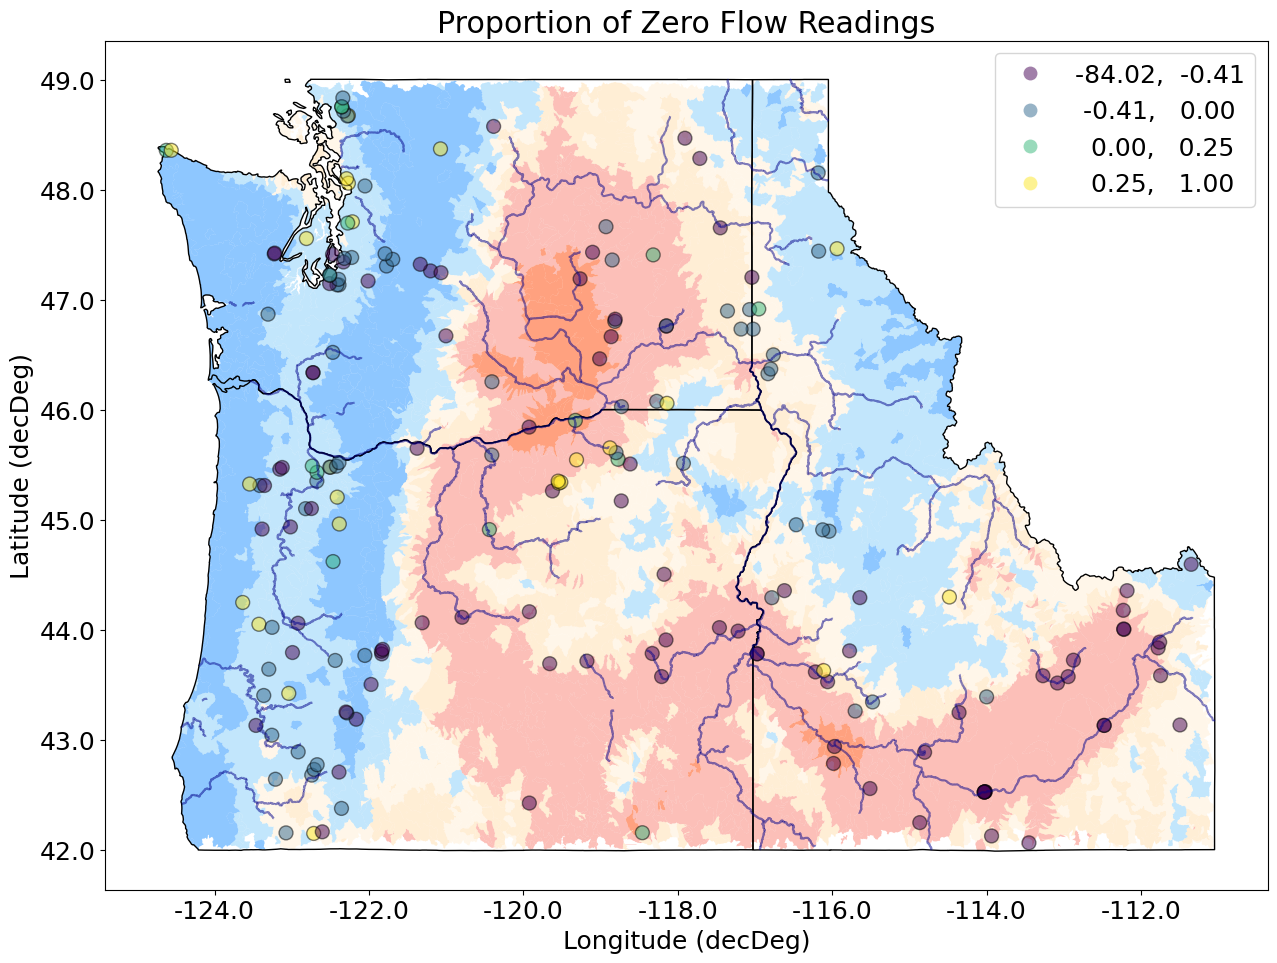

In [12]:
plotMetricMap(model = "vic",
             metric = "kge")